In [4]:
%matplotlib inline

import torch
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

trainset = datasets.MNIST('~/python/MNIST', download=True, train=True, transform= transform)
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size = 64)

testset = datasets.MNIST('~/python/MNIST', download=True, train=False, transform= transform)
testloader = torch.utils.data.DataLoader(testset, shuffle=True, batch_size = 64)


In [42]:
from collections import OrderedDict
import torch.optim as optim

model = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(28*28, 128)),
    ('relu', nn.ReLU()),
    ('dropout', nn.Dropout(0.2)),
    ('fc2', nn.Linear(128, 64)),
    ('relu', nn.ReLU()),
    ('dropout', nn.Dropout(0.2)),    
    ('fc3', nn.Linear(64, 10)),   
    ('out', nn.LogSoftmax(dim=1))
]))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.003)


In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Running in', device)

Running in cpu


In [46]:

test_loss = 0
epoch = 5

model.to(device)

for e in range(epoch):
    running_loss = 0
    for images, labels in trainloader:
        model.train()
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        images= images.view(images.shape[0], -1)
        output = model(images)
        loss = criterion(output, labels)
        running_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    else:
        validation_loss = 0
        accuracy = 0
        for images, labels in testloader:
            model.eval()
            with torch.no_grad():
                images, labels = images.to(device), labels.to(device)
                images = images.view(images.shape[0], -1)
                out = model(images)
                loss = criterion(out, labels)
                validation_loss += loss.item()
                ps = torch.exp(out)
                t_ps, t_class = ps.topk(1)
                equality = t_class == labels.view(*t_class.shape)
                accuracy += torch.mean(equality.type(torch.FloatTensor))
        
        print(f'Total running loss ({e}):', running_loss/len(trainloader))
        print(f'Total validation loss ({e}):', validation_loss/len(testloader))

print('Accuracy Rate:{:.3f}'.format(accuracy/len(testloader) * 100))
        

Total running loss (0): 0.3041553972666261
Total validation loss (0): 0.2580858715305662
Total running loss (1): 0.2928104834325278
Total validation loss (1): 0.24864233180785636
Total running loss (2): 0.2814943631336506
Total validation loss (2): 0.24233569816988745
Total running loss (3): 0.27208760808081006
Total validation loss (3): 0.23349576016330414
Total running loss (4): 0.26254334196702506
Total validation loss (4): 0.22311285380155418
Accuracy Rate:93.641


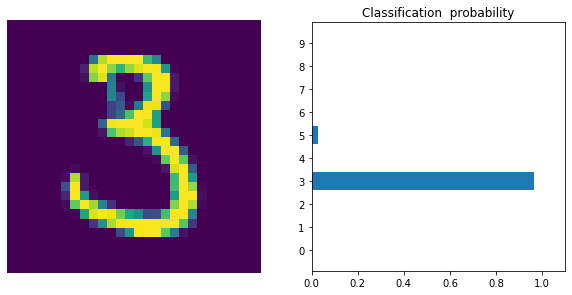

In [67]:
images, labels = next(iter(testloader))
image = images[0]

ps = torch.exp(model(image.view(image.shape[0], -1)))

image = image.squeeze()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
ax1.axis('off')
ax1.imshow(image)

ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_xlim(0,1.1)
ax2.set_title('Classification  probability')
ax2.barh(np.arange(10), ps.detach().squeeze())
plt.tight_layout = True